# Alpha lifetime

An script to compute alpha lifetime.

In [1]:
from __future__ import print_function, division
%load_ext autoreload
%autoreload 2
import sys
import os
import operator
import functools
import textwrap
import copy
import time
from glob import glob
import math
print("Running on ", time.asctime())

import textwrap
import numpy as np
import pandas as pd
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

from invisible_cities.database import load_db
from invisible_cities.core.system_of_units_c import units
#import invisible_cities.core.system_of_units_c as units
from invisible_cities.core.core_functions import timefunc, flat
import invisible_cities.core.fit_functions as fitf
import invisible_cities.core.mpl_functions as mpl
from invisible_cities.core.mpl_functions import plot_pmt_waveforms, plot_pmt_signals_vs_time_mus, \
              plot_signal_vs_time_mus
from invisible_cities.core.core_functions import in_range

import invisible_cities.reco.tbl_functions as tbl
from invisible_cities.reco.pmaps_functions import plot_s12, width, integrate_charge
import invisible_cities.reco.pmaps_functions as pmapf
from invisible_cities.reco.params import S12Params, ThresholdParams


sys.path.append('/Users/alej/Desktop/Valencia/nextic/ICARO')

from icaro.core.event_pmaps import EventPmaps, print_s12, print_s2si
from icaro.core.hst_functions import labels, hist, doublehist, hist2d, pdf, scatter, profile_and_scatter,\
                              doublescatter, covariance, reso, gausstext, plot_profile_histogram 
from icaro.core.kdst_functions import load_dst, event_rate, profile_and_fit, print_fit, chi2


from scipy.optimize import curve_fit
from icaro.core.kdst_functions import load_dst, event_rate, profile_and_fit, \
                               profile_and_fit_radial, print_fit, MapXY, chi2,\
                               time_from_timestamp, lifetime

pi = np.pi



Running on  Wed May 10 00:30:44 2017


In [2]:
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2017-05-10 00:30:47


In [3]:
def plot_options(figsize=(6,6), fontsize=15):
    plt.rcParams["figure.figsize"]          = figsize
    plt.rcParams["font.size"]               = fontsize
    plt.rcParams["figure.max_open_warning"] = 100

In [4]:
plt.rcParams["figure.figsize"]          = 6, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

### Run Parameters

In [5]:
runs = [3628,
        3645,
        3715,
        3724,
        3733,
        3741,
        3753,
        3756,
        3758,
        3762,
        3767,
        3769,
        3772,
        3774,
        3782,
        3784,
        3788,
        3790,
        3793,
        3795,
        3822,
        3824,
        3826,
        3829,
        3883,
        3888,
        3897,
        3900,
        3903,
        3905]

In [6]:
tr = [
    1.16,
    1.11,
    1.29,
    1.32,
    1.26,
    2.29,
    2.94,
    3.02,
    3.03,
    3.06,
    2.47,
    2.59,
    2.72,
    2.97,
    3.12,
    3.25,
    3.53,
    3.88,
    4.13,
    4.35,
    4.54,
    5.01,
    5.57,
    6.46,
    8.01,
    7.42,
    7.45,
    7.39,
    6.58,
    5.68,
     ]

revts = [4388,
        4230,
        4696,
        4764,
        4850,
        9179,
        12907,
        11281,
        13975,
        25228,
        9332,
        10324,
        10527,
        11843,
        14396,
        14150,
        12037,
        19068,
        20776,
        18040,
        26250,
        26009,
        23119,
        30302,
        36703,
        27774,
        44509,
        64079,
        2021213,
        835264]

In [7]:
revts = np.array(revts[::-1])
trigr = np.array(tr[::-1])
print(len(runs), len(revts), len(trigr))

30 30 30


using data set with length 115070
t0 = 2017-04-12 19:39:52 (index = 0) t1 = 2017-04-14 12:13:42 (index = 115070)
bin length = 38356
 ---fit over events between 0 and 38355
time0 = 2017-04-12 19:39:52 time1 = 2017-04-13 10:37:11
size of time leg = 38355
fit par[0] = 63553.92026624662 error = 82.32768465671485
fit par[1] = -343.8561604867747 error = 0.643930516504672
degrees of freedom = 2
chi2 = 0.9995236097024833
 ---fit over events between 38356 and 76711
time0 = 2017-04-13 10:37:14 time1 = 2017-04-13 23:33:26
size of time leg = 38355
fit par[0] = 64223.639953239755 error = 34.90053909557532
fit par[1] = -322.7438460186366 error = 0.237036345141181
degrees of freedom = 2
chi2 = 0.3949475541284956
 ---fit over events between 76712 and 115067
time0 = 2017-04-13 23:33:26 time1 = 2017-04-14 12:13:39
size of time leg = 38355
fit par[0] = 61559.33516646004 error = 238.96751524283428
fit par[1] = -356.6041228020998 error = 2.0704355067071796
degrees of freedom = 2
chi2 = 2.943397674984194
us

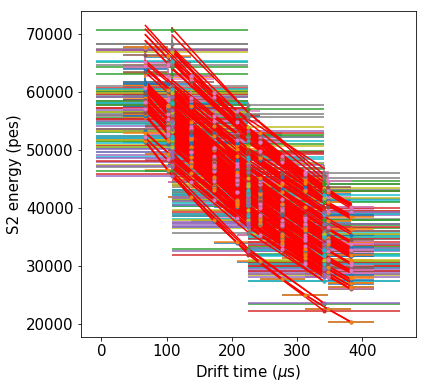

In [8]:
LT  = {}
times = []
times_all = []
lifetimes_all = []
elambdas_all = []
lifetimes = []
elambdas = []
s1es = []
s2es = []
zs = []
eff = []
for i, run_number in enumerate(runs):
    
    DataPMT = load_db.DataPMT(run_number)
    DataSiPM = load_db.DataSiPM(run_number)
    xs = DataSiPM.X.values
    ys = DataSiPM.Y.values
    
    ifile = os.path.join(os.environ['IC_DATA'], 'LSC/kdst/dst_{}.root.h5'.format(run_number)) 
    full = load_dst(ifile)
    full.head()
    
    r = event_rate(full)
    st = datetime.datetime.fromtimestamp(full.time[-1:]).strftime('%Y-%m-%d %H:%M:%S')
    core = full[full.R < 100]     # Cuts
    
    
    zrange =   50, 400
    Erange = 1e+3, 70e3
    nbins = 10
    F, x, y, sy = profile_and_fit(core.Z, core.S2e, 
                    xrange=zrange, 
                    yrange=Erange, 
                    nbins=nbins, 
                    fitpar=(50000,-300), label=("Drift time ($\mu$s)", "S2 energy (pes)"))
    

    
    cz = core[in_range(core.Z, 50, 400)]
    
    #cz = full
    
    #print('=======')
    #print(len(full))
    #print(len(cz))
    cz = full
    cz = cz [cz.S2e  >  400*units.pes * 11] # michel sorel cuts
    #print('s2',len(cz))
    cz = cz [cz.S1e   >   100*units.pes * 11] 
    #print('s1',len(cz))
    cz = cz [cz.S2w   > 3.5] # units of mus!!!
    cz = cz [cz.S2w   <  25] # units of mus!!! 
    #print('s2w',len(cz))
    cz = cz [cz.S1w   >  300*units.ns]
    cz = cz [cz.S1w   < 1000*units.ns] 
    #print('s1w',len(cz))
    cz = cz [cz.S1t   >  100*units.mus]
    cz = cz [cz.S2t   <  750*units.mus]
    #print('times',len(cz))
    cz = cz [cz.R     <  100*units.mm] # fidc
    aev = len(set(cz.event))

    eff.append(aev / revts[i])
    
    s1es.append(cz.S1e.mean())
    s2es.append(cz.S2e.mean())
    zs  .append(cz.Z  .mean())
    
    zrange =   50, 400
    Erange = 1e+3, 70e3
    nbins = 10
    F, x, y, sy = profile_and_fit(cz.Z, cz.S2e, 
                        xrange=zrange, 
                        yrange=Erange, 
                        nbins=nbins, 
                        fitpar=(50000,-300), label=("Drift time ($\mu$s)", "S2 energy (pes)"))
    st0 = time_from_timestamp(full.time[0])
    st1 = time_from_timestamp(full.time[-1:])
    CHI2, LAMBDA, ELAMBDA, TSTAMP, TIME = lifetime(dst=cz, zrange=(50,400), Erange=(1e+3, 80e3), nbins=3)

    times.append(TIME[np.argmin(ELAMBDA)])
    lifetimes.append(-np.array(LAMBDA)[np.argmin(ELAMBDA)])
    elambdas .append( np.min (ELAMBDA))
    LT[run_number] = -np.array(LAMBDA)[np.argmin(ELAMBDA)]
    
    times_all.extend(TIME)
    lifetimes_all.extend(-np.array(LAMBDA))
    elambdas_all.extend(ELAMBDA)



In [9]:
times = np.array(times)
times_all = np.array(times_all)
lifetimes_all = np.array(lifetimes_all)
elambdas_all = np.array(elambdas_all)
lifetimes = np.array(lifetimes)
elambdas = np.array(elambdas)
s1es = np.array(s1es)
s2es = np.array(s2es)
zs = np.array(zs)
eff = np.array(eff)

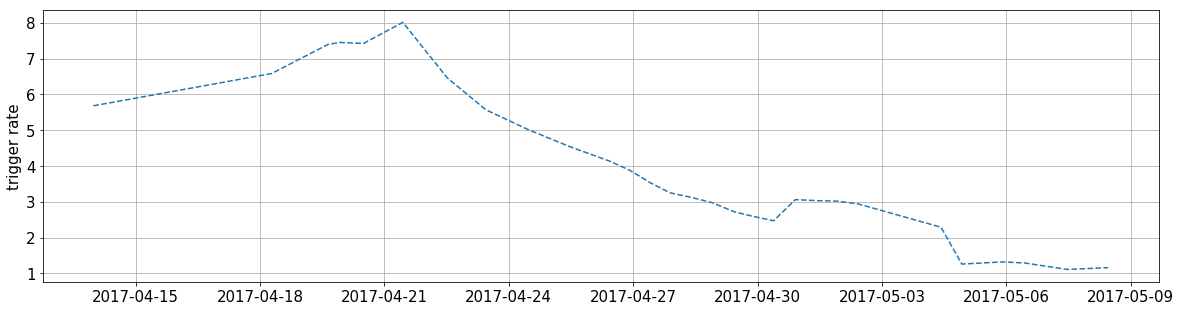

In [10]:
plt.figure(figsize=(20,5))
plt.plot(times, trigr, linestyle='--')
plt.ylabel('trigger rate')
plt.grid(True)
plt.show()

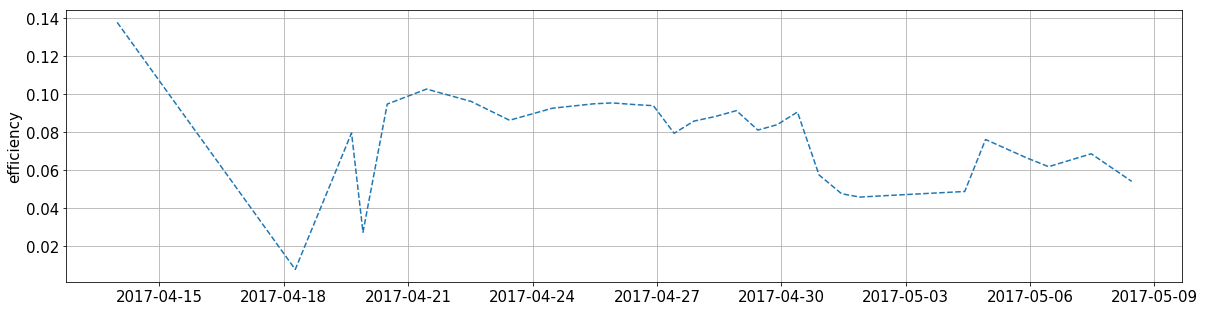

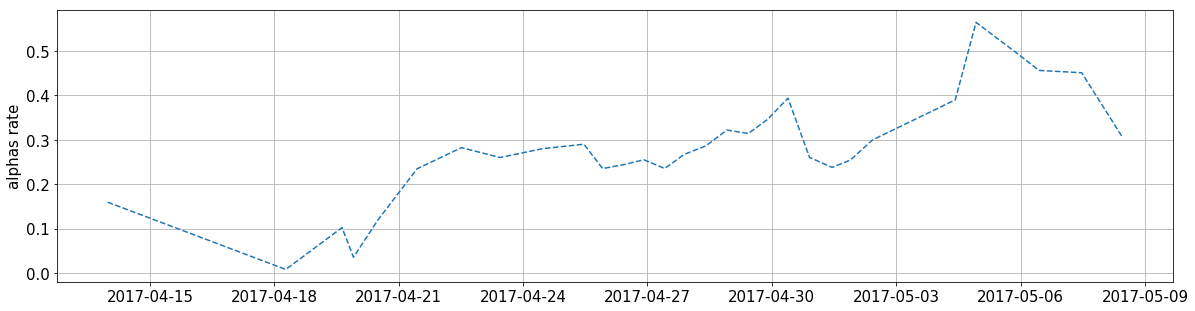

In [11]:
plt.figure(figsize=(20,5))
plt.plot(times, eff, linestyle='--')
plt.ylabel('efficiency')
plt.grid(True)
plt.show()

plt.figure(figsize=(20,5))
plt.plot(times, np.array(eff) * (tr), linestyle='--')
plt.ylabel('alphas rate')
plt.grid(True)
plt.show()

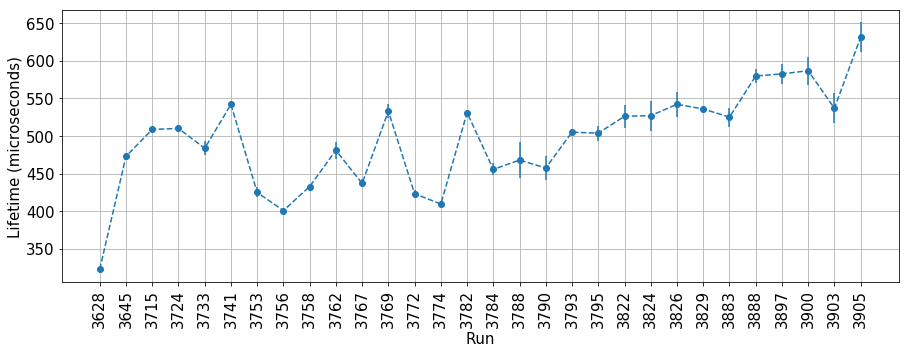

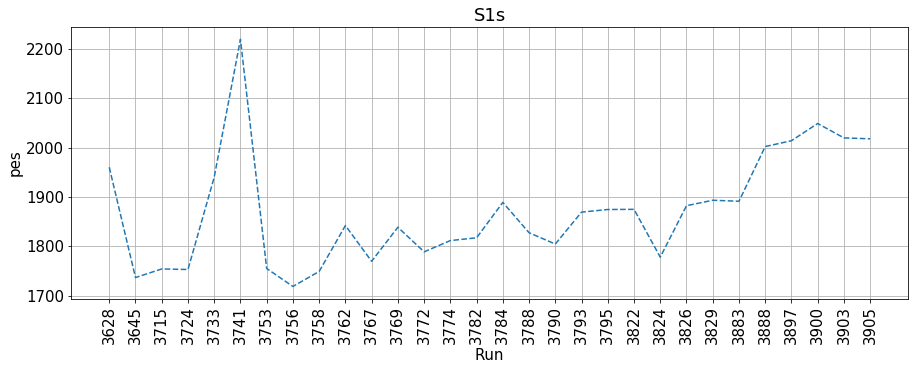

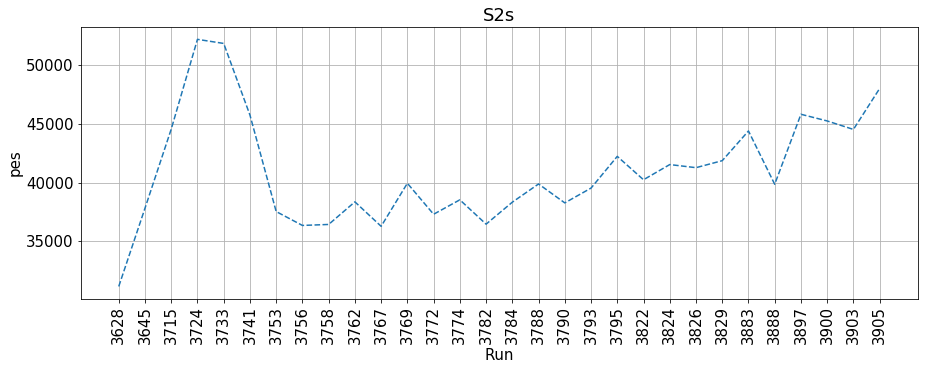

In [12]:
plt.figure(figsize=(15,5))
#plt.plot(times, lifetimes)
plt.errorbar(range(len(lifetimes)), lifetimes, yerr=elambdas, linestyle='--', fmt='o')
plt.xticks(range(len(lifetimes)), runs, rotation='vertical')
plt.grid(True)
plt.xlabel('Run')
plt.ylabel('Lifetime (microseconds)')
plt.show()

plt.figure(figsize=(15,5))
#plt.plot(times, lifetimes)
plt.plot(range(len(lifetimes)), s1es, linestyle='--')
plt.xticks(range(len(lifetimes)), runs, rotation='vertical')
plt.grid(True)
plt.xlabel('Run')
plt.title('S1s')
plt.ylabel('pes')
plt.show()

plt.figure(figsize=(15,5))
#plt.plot(times, lifetimes)
plt.plot(range(len(lifetimes)), s2es, linestyle='--')
plt.xticks(range(len(lifetimes)), runs, rotation='vertical')
plt.grid(True)
plt.title('S2s')
plt.xlabel('Run')
plt.ylabel('pes')
plt.show()


In [37]:
list(zip(runs,lifetimes,elambdas))

[(3628, 322.74384601863659, 0.23703634514118099),
 (3645, 472.81228027561514, 2.1388161148424767),
 (3715, 508.58406882297669, 0.66459517105472643),
 (3724, 509.9168334156999, 3.9220335210232173),
 (3733, 483.5264601715009, 9.247249142758017),
 (3741, 541.78140900434403, 1.1159143107471934),
 (3753, 424.86088678206607, 6.7263726222364086),
 (3756, 400.73939652671743, 2.6485999224782022),
 (3758, 432.71751020815981, 0.18840908372544199),
 (3762, 480.87663976186718, 11.400103892624074),
 (3767, 436.87319354201162, 5.4504900139519838),
 (3769, 532.9620700541476, 9.6586854510605491),
 (3772, 423.06163243866501, 5.6594254315951824),
 (3774, 409.41792334313601, 4.0097046656318298),
 (3782, 530.89702155392524, 2.9461520557564898),
 (3784, 455.48284519637252, 8.008097360548426),
 (3788, 467.86438961120678, 23.669791085537593),
 (3790, 457.31866595972514, 16.53662530190854),
 (3793, 504.9175553321428, 3.6187841007160011),
 (3795, 503.67353858012717, 10.105685812682676),
 (3822, 526.026217909306

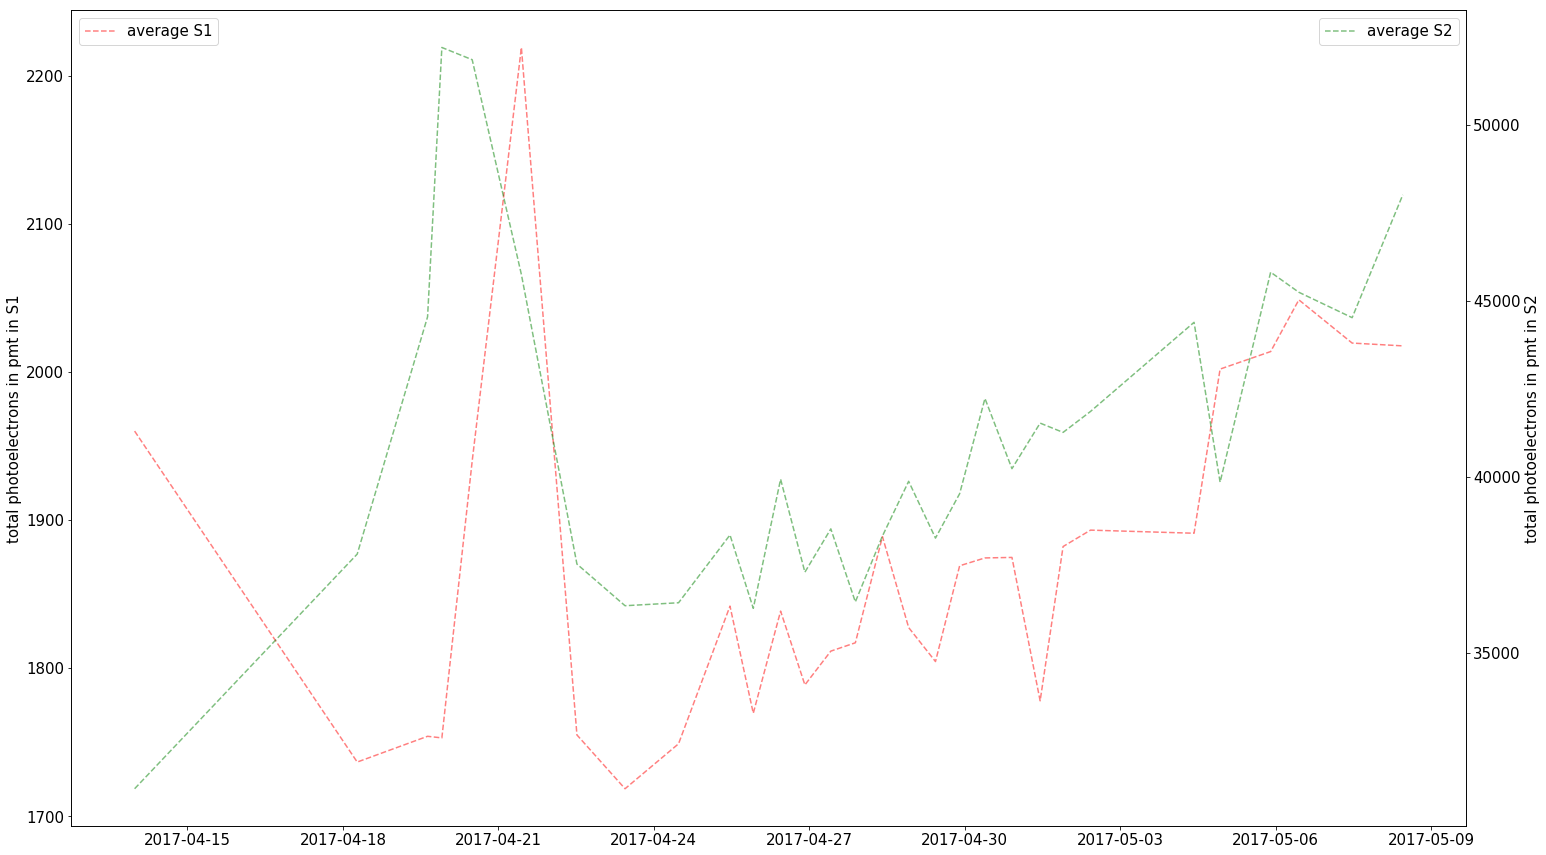

In [53]:
fig, ax1 = plt.subplots(figsize=(25,15))
#ax1.errorbar(times, lifetimes, yerr=elambdas, linestyle='--', fmt='o')
#ax1.set_ylabel('lifetime (microseconds)')
ax2 = ax1.twinx()
ax1.plot(times, s1es, c='red', alpha=.5, linestyle='--', label='average S1')
ax1.legend(loc=2)
ax1.set_ylabel('total photoelectrons in pmt in S1')
ax2.plot(times, s2es, c='green', alpha=.5, linestyle='--', label='average S2')
ax2.legend(loc=1)
ax2.set_ylabel('total photoelectrons in pmt in S2')
plt.show()

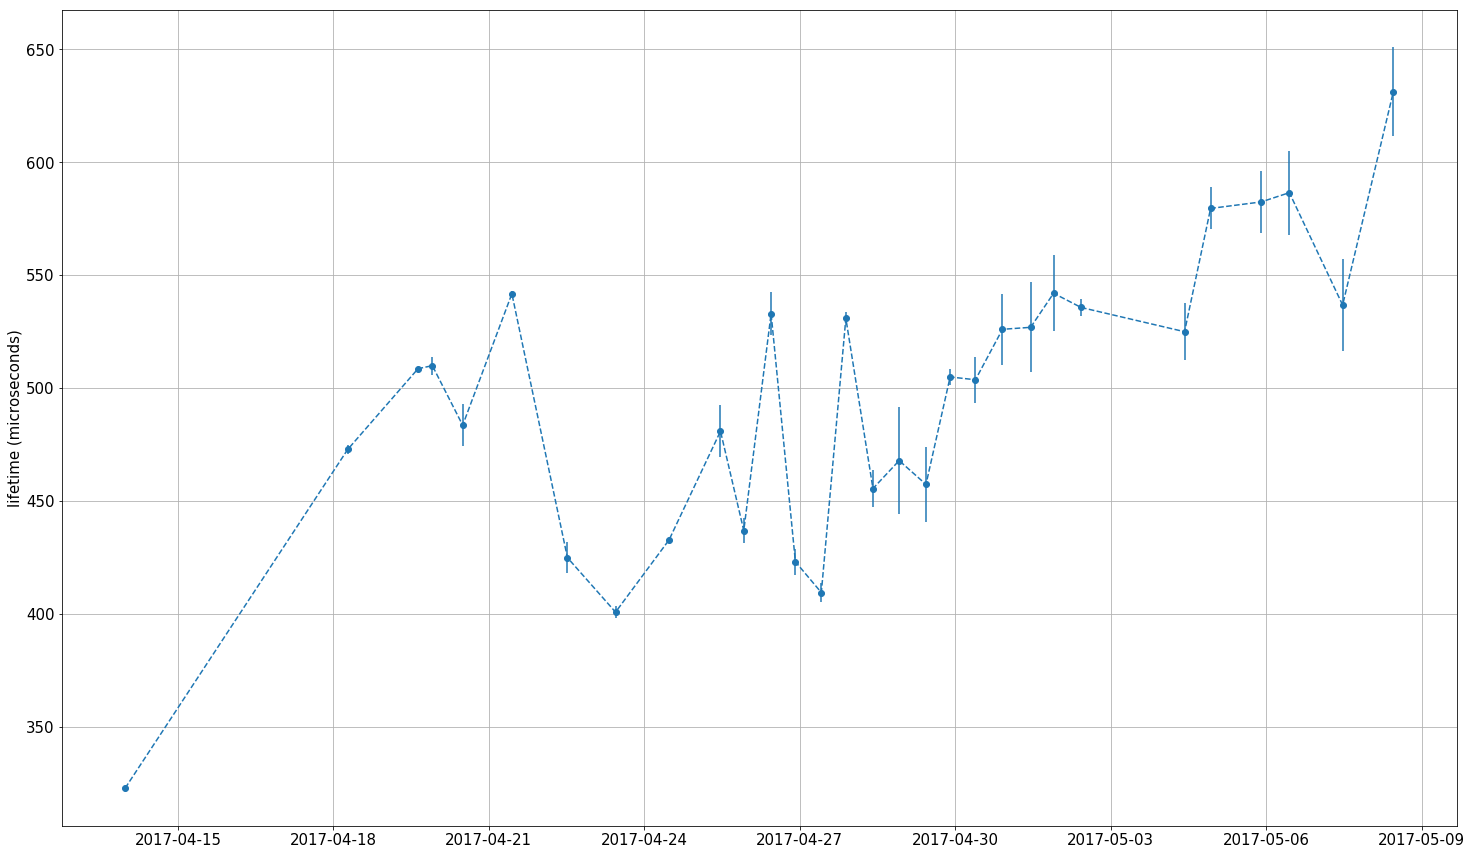

In [39]:
fig, ax1 = plt.subplots(figsize=(25,15))
ax1.errorbar(times, lifetimes, yerr=elambdas, linestyle='--', fmt='o')
ax1.set_ylabel('lifetime (microseconds)')
#ax2 = ax1.twinx()
#ax2.plot(times, s1es, c='red', alpha=.5, linestyle='--')
#ax2.plot(times, s2es, c='green', alpha=.5, linestyle='--')
#ax2.set_ylabel('pes / mm from anode')
plt.grid(True)
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(25,15))
ax1.errorbar(times, lifetimes, yerr=elambdas, linestyle='--', fmt='o')
ax1.set_ylabel('lifetime (microseconds)')
#ax2 = ax1.twinx()
#ax2.plot(times, s1es, c='red', alpha=.5, linestyle='--')
#ax2.plot(times, s2es, c='green', alpha=.5, linestyle='--')
#ax2.set_ylabel('pes / mm from anode')
plt.grid(True)
plt.show()

llifetimes = list(lifetimes[])

In [22]:
plog = os.path.join(os.environ['IC_DATA'], 'LSC/logs/pressure/Plot_Log/')

pfiles = [
          plog + 'GAS_Log_2017-04-15.txt',
          plog + 'GAS_Log_2017-04-16.txt',
          plog + 'GAS_Log_2017-04-17.txt',
          plog + 'GAS_Log_2017-04-18.txt',
          plog + 'GAS_Log_2017-04-19.txt',
          plog + 'GAS_Log_2017-04-20.txt',
          plog + 'GAS_Log_2017-04-21.txt',
          plog + 'GAS_Log_2017-04-22.txt',
          plog + 'GAS_Log_2017-04-23.txt',
          plog + 'GAS_Log_2017-04-24.txt',
          plog + 'GAS_Log_2017-04-25.txt',
          plog + 'GAS_Log_2017-04-26.txt',
          plog + 'GAS_Log_2017-04-27.txt',
          plog + 'GAS_Log_2017-04-28.txt',
          plog + 'GAS_Log_2017-04-29.txt',
          plog + 'GAS_Log_2017-04-30.txt',
          plog + 'GAS_Log_2017-05-01.txt',
          plog + 'GAS_Log_2017-05-02.txt',
          plog + 'GAS_Log_2017-05-03.txt',
          plog + 'GAS_Log_2017-05-04.txt',
          plog + 'GAS_Log_2017-05-05.txt']
f0 = pd.read_csv(pfiles[0], skiprows=2, sep=None, engine='python', decimal=",")

T  =[]
pg3=[]
pg6=[]
for f in pfiles: 
    f = pd.read_csv(f, skiprows=2, sep=None, engine='python')

    for d, t, g3, g6 in zip(f['Date'].values, f['Hour'].values, f['PG3'].values, f['PG6'].values):
        if len(t)==7: t = '0' + t
        T.append(datetime.datetime.strptime(d +' '+ t,'%d/%m/%Y %H:%M:%S'))
        pg3.append(g3)
        pg6.append(g6)
        
days = 30
tlog = os.path.join(os.environ['IC_DATA'], 'LSC/logs/temperature/Data/')
tfiles = [tlog + 'PWR_Data_Report_2017-04-15.txt',
          tlog + 'PWR_Data_Report_2017-04-16.txt',
          tlog + 'PWR_Data_Report_2017-04-17.txt',
          tlog + 'PWR_Data_Report_2017-04-18.txt',
          tlog + 'PWR_Data_Report_2017-04-19.txt',
          tlog + 'PWR_Data_Report_2017-04-20.txt',
          tlog + 'PWR_Data_Report_2017-04-21.txt',
          tlog + 'PWR_Data_Report_2017-04-22.txt',
          tlog + 'PWR_Data_Report_2017-04-23.txt',
          tlog + 'PWR_Data_Report_2017-04-24.txt',
          tlog + 'PWR_Data_Report_2017-04-25.txt',
          tlog + 'PWR_Data_Report_2017-04-26.txt',
          tlog + 'PWR_Data_Report_2017-04-27.txt',
          tlog + 'PWR_Data_Report_2017-04-28.txt',
          tlog + 'PWR_Data_Report_2017-04-29.txt',
          tlog + 'PWR_Data_Report_2017-04-30.txt',
          tlog + 'PWR_Data_Report_2017-05-01.txt',
          tlog + 'PWR_Data_Report_2017-05-02.txt',
          tlog + 'PWR_Data_Report_2017-05-03.txt',
          tlog + 'PWR_Data_Report_2017-05-04.txt',
          tlog + 'PWR_Data_Report_2017-05-05.txt',
          tlog + 'PWR_Data_Report_2017-05-06.txt',
          tlog + 'PWR_Data_Report_2017-05-07.txt',
          tlog + 'PWR_Data_Report_2017-05-08.txt',
          tlog + 'PWR_Data_Report_2017-05-09.txt',]
f0 = pd.read_csv(tfiles[0], skiprows=2, sep='\s+', engine='python')
Tt=[]
dbs=[]
for f in tfiles: 
    f = pd.read_csv(f, skiprows=2, sep='\s+', engine='python')

    for i, (d, t) in enumerate(zip(f['Date'].values, f['Hour'].values)):
        if len(t)==7: t = '0' + t
        Tt.append(datetime.datetime.strptime(d +' '+ t,'%d/%m/%Y %H:%M:%S'))
        dbs.append([f['DB1_Temp(�C)'][i],  f['DB2_Temp(�C)'] [i], f['DB3_Temp(�C)'] [i],
                    f['DB4_Temp(�C)'][i],  f['DB5_Temp(�C)'] [i], f['DB6_Temp(�C)'] [i],
                    f['DB7_Temp(�C)'][i],  f['DB8_Temp(�C)'] [i], f['DB9_Temp(�C)'] [i],
                    f['DB10_Temp(�C)'][i], f['DB11_Temp(�C)'][i], f['DB12_Temp(�C)'][i],
                    f['DB13_Temp(�C)'][i], f['DB14_Temp(�C)'][i], f['DB15_Temp(�C)'][i],
                    f['DB16_Temp(�C)'][i], f['DB17_Temp(�C)'][i], f['DB18_Temp(�C)'][i],
                    f['DB19_Temp(�C)'][i], f['DB20_Temp(�C)'][i], f['DB21_Temp(�C)'][i],
                    f['DB22_Temp(�C)'][i], f['DB23_Temp(�C)'][i], f['DB24_Temp(�C)'][i],
                    f['DB25_Temp(�C)'][i], f['DB26_Temp(�C)'][i], f['DB27_Temp(�C)'][i],
                    f['DB28_Temp(�C)'][i]])


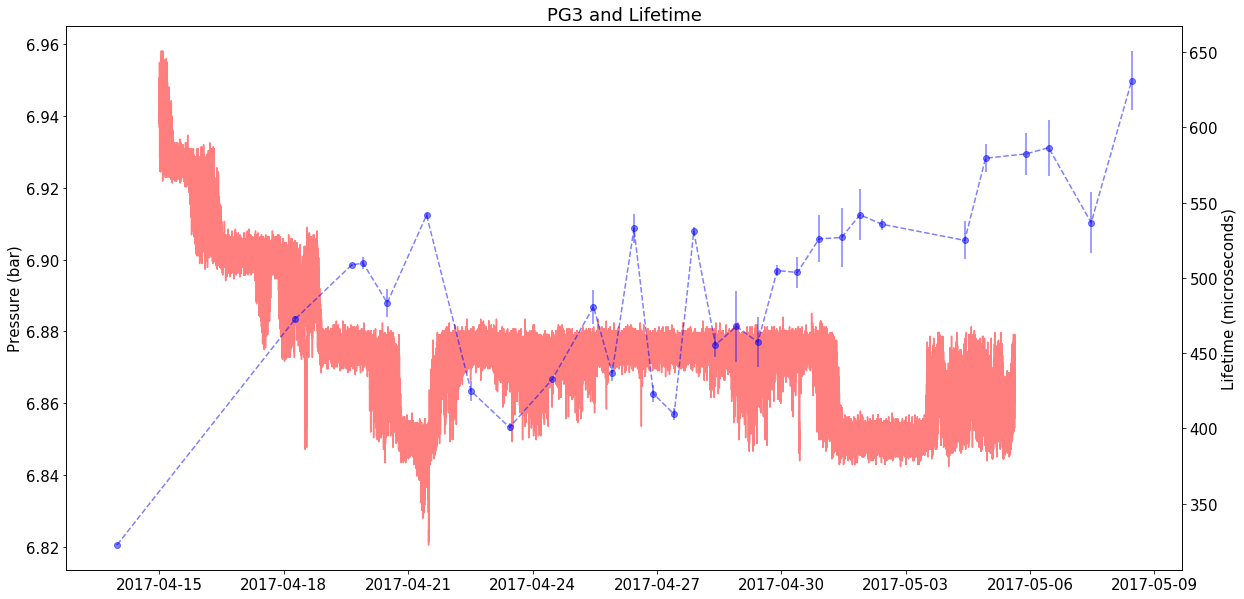

In [23]:
fig, ax1 = plt.subplots(figsize=(20, 10))
ax1.plot(T, [float(v.replace(',','.')) for v in pg3],alpha=.5, c='red')
ax1.set_ylabel('Pressure (bar)')
ax2=ax1.twinx()
ploterr = elambdas
ax2.errorbar(times, lifetimes, yerr=ploterr, linestyle='--', fmt='o', c='blue', alpha=.5)
ax2.set_ylabel('Lifetime (microseconds)')
plt.title('PG3 and Lifetime')
plt.show()

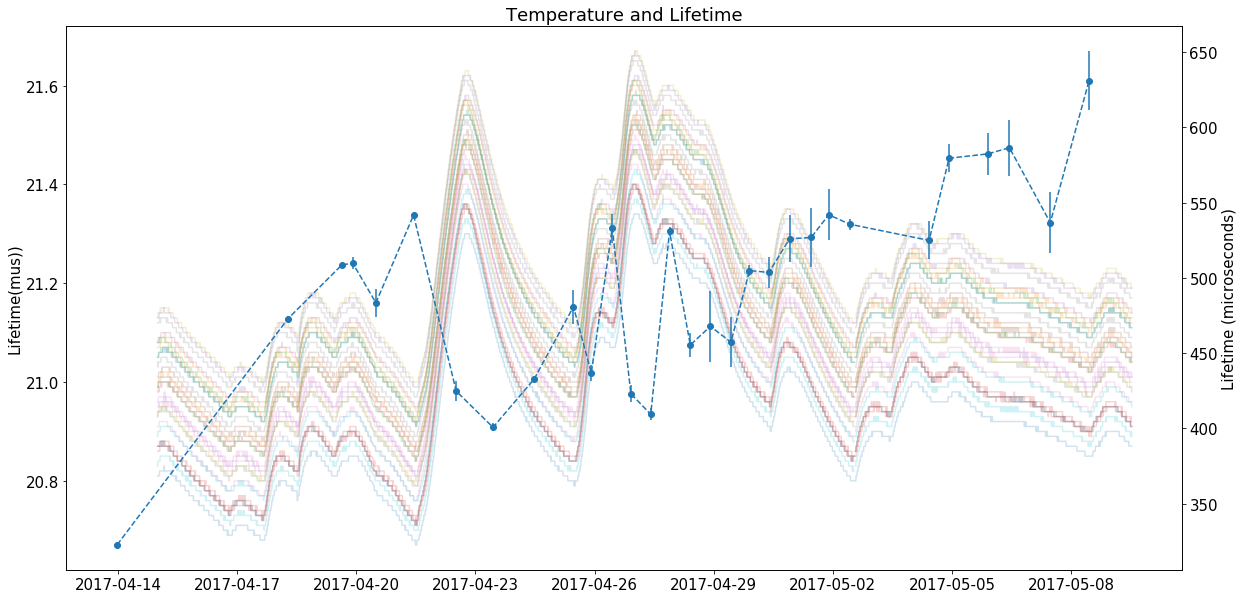

In [24]:
fig, ax1 = plt.subplots(figsize=(20, 10))
ax1.plot(Tt, dbs, alpha=.2)
#ax1.plot(Tt, np.array(dbs).mean(axis=1), c='red', alpha=.5)
ax1.set_ylabel('Lifetime(mus))')
ax2=ax1.twinx()
ploterr = elambdas
ax2.errorbar(times, lifetimes, yerr=ploterr, linestyle='--', fmt='o')
ax2.set_ylabel('Lifetime (microseconds)')
plt.title('Temperature and Lifetime')
plt.show()

In [19]:
runs

[3628,
 3645,
 3715,
 3724,
 3733,
 3741,
 3753,
 3756,
 3758,
 3762,
 3767,
 3769,
 3772,
 3774,
 3782,
 3784,
 3788,
 3790,
 3793,
 3795,
 3822,
 3824,
 3826,
 3829,
 3883,
 3888,
 3897,
 3900,
 3903,
 3905]

In [20]:
lifetimes

array([ 322.74384602,  472.81228028,  508.58406882,  509.91683342,
        483.52646017,  541.781409  ,  424.86088678,  400.73939653,
        432.71751021,  480.87663976,  436.87319354,  532.96207005,
        423.06163244,  409.41792334,  530.89702155,  455.4828452 ,
        467.86438961,  457.31866596,  504.91755533,  503.67353858,
        526.02621791,  526.9033844 ,  541.99805886,  535.71189297,
        524.9629086 ,  579.57297935,  582.44562452,  586.5500095 ,
        536.7743464 ,  631.17944375])

In [21]:
elambdas

array([  0.23703635,   2.13881611,   0.66459517,   3.92203352,
         9.24724914,   1.11591431,   6.72637262,   2.64859992,
         0.18840908,  11.40010389,   5.45049001,   9.65868545,
         5.65942543,   4.00970467,   2.94615206,   8.00809736,
        23.66979109,  16.5366253 ,   3.6187841 ,  10.10568581,
        15.6121537 ,  19.87553323,  16.85258541,   3.76938973,
        12.65552372,   9.32681694,  13.6990857 ,  18.57122736,
        20.29630419,  19.69640677])